In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import json
import xarray
from pathlib import Path
import dask
from tqdm import tqdm

## Preprocess

In [9]:
prefix = '/g/data/x77/jm0124/ocean'

def sst():
    prefix = '/g/data/x77/jm0124/ocean'
    # path = '/home/156/cn1951/kae-cyclones/input/sstday.npy'
    path = '/g/data/x77/jm0124/ocean/sstday.npy'
    X = np.load(path)
    t, m, n = X.shape
    indices = range(3600)
    training_idx, valid_idx, test_idx = indices[220:1315], indices[1315:2557], indices[2557:2922] # 6 years
    
    # mean subtract
    X = X.reshape(-1,m*n)
    X -= X.mean(axis=0)    
    
    # scale 
    X = X.reshape(-1,m*n)
    X = 2 * (X - np.min(X)) / np.ptp(X) - 1
    X = X.reshape(-1,m,n) 
    
    # split into train, valid and test set
    
    X_train = X[training_idx]  
    X_valid = X[valid_idx]
    X_test = X[test_idx]
    
    np.save(f'{prefix}/sstday_train.npy', X_train)
    np.save(f'{prefix}/sstday_valid.npy', X_valid)
    np.save(f'{prefix}/sstday_test.npy', X_test)

    return X_train, X_valid, X_test, m, n

In [10]:
sst()

(array([[[0.2610705 , 0.27098513, 0.2774123 , ..., 0.2708447 ,
          0.2725873 , 0.2730229 ],
         [0.26274228, 0.2722441 , 0.27820063, ..., 0.26982963,
          0.27314556, 0.27748108],
         [0.26836777, 0.27740026, 0.2815336 , ..., 0.275033  ,
          0.27932715, 0.28374207],
         ...,
         [0.20286238, 0.20286238, 0.20286238, ..., 0.47588623,
          0.47862363, 0.4763602 ],
         [0.20286238, 0.20286238, 0.20286238, ..., 0.48712564,
          0.48646808, 0.48315907],
         [0.20286238, 0.20286238, 0.20286238, ..., 0.48575592,
          0.48911333, 0.49041247]],
 
        [[0.27239287, 0.2777785 , 0.2804314 , ..., 0.25121927,
          0.24918807, 0.24811387],
         [0.27708375, 0.28054714, 0.28197467, ..., 0.25322354,
          0.2535205 , 0.25483668],
         [0.28270924, 0.28570318, 0.2868173 , ..., 0.25842726,
          0.2612114 , 0.26260698],
         ...,
         [0.20286238, 0.20286238, 0.20286238, ..., 0.4751315 ,
          0.47786868, 0.

In [11]:
path = f'{prefix}/sstday_train.npy'
X_train = np.load(path)

In [12]:
#X_train.shape[0], X_valid.shape[0], X_test.shape[0]

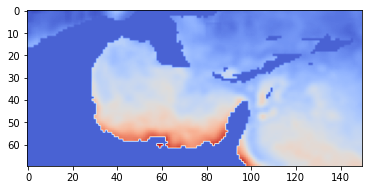

In [18]:
plt.imshow(X_train[1094], cmap='coolwarm')
plt.show()

## Generate dataset

In [62]:
class OceanToOcean(Dataset):
    def __init__(self, prediction_length, partition_name='train'):
        self.ocean_array = np.load(f"/home/156/cn1951/kae-cyclones/input/sstday_{partition_name}.npy")
        self.prediction_length = prediction_length
    
    def __len__(self):
        return self.ocean_array.shape[0]
    
    def __getitem__(self, idx):
        i = 0
        for ocean_run in self.ocean_array:
            j = self.prediction_length
            for time_step in ocean_run[self.prediction_length:-self.prediction_length]:
                if i == idx:
                    return torch.from_numpy(ocean_run[j-self.prediction_length:j+self.prediction_length]), torch.from_numpy(np.flip(ocean_run[j-self.prediction_length:j+self.prediction_length], 0).copy())
                j += 1
                i += 1

In [63]:
def generate_ocean_ds():
    train_ds = OceanToOcean(4, 'train')
    val_ds = OceanToOcean(4, 'valid')
    test_ds = OceanToOcean(4, 'test')

    return train_ds, val_ds, test_ds

In [68]:
train_ds, val_ds, test_ds = generate_ocean_ds()
loader = torch.utils.data.DataLoader(train_ds, batch_size=64, num_workers=8, pin_memory=True, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_ds, batch_size=64, num_workers=8, pin_memory=True, shuffle=True)
input_size = 2
alpha = 4
beta = 4
learning_rate = 1e-4

In [76]:
img, output = next(iter(loader))
img.shape

torch.Size([64, 8, 150])

## Load trained model

In [31]:
from models import *

In [41]:
saved_models_path = '/home/156/cn1951/kae-cyclones/saved_models/ELEI-eigenloss_and_eigeninit-final.pt'

model = koopmanAE(b=16, steps=4, steps_back=4, alpha=16, eigen_init=True, input_size=150).to(0)
model.load_state_dict(torch.load(saved_models_path))
model.eval()

In eigen initialisation
[ 1.9000695 -1.3011057j  -0.17601435+0.601464j   -0.84215266+0.43585145j
 -1.7740891 -0.90613854j  0.8458511 -1.5421984j   1.9230328 -1.2858156j
  1.5648412 -0.8380359j   0.09560107-0.8313264j   1.6201988 -1.8076323j
  0.94429475-0.21173549j  0.4252935 -1.0833628j   0.6704159 -0.9004774j
  0.3741784 +1.1069468j   0.715604  -0.7500341j  -0.45531556+1.2417898j
  0.57926095-1.3242528j ]


koopmanAE(
  (encoder): encoderNetSimple(
    (fc1): Linear(in_features=150, out_features=256, bias=True)
    (fc2): Linear(in_features=256, out_features=256, bias=True)
    (fc3): Linear(in_features=256, out_features=16, bias=True)
  )
  (decoder): decoderNetSimple(
    (fc1): Linear(in_features=16, out_features=256, bias=True)
    (fc2): Linear(in_features=256, out_features=256, bias=True)
    (fc3): Linear(in_features=256, out_features=150, bias=True)
  )
  (dynamics): dynamics(
    (dynamics): Linear(in_features=16, out_features=16, bias=False)
  )
  (backdynamics): dynamics_back(
    (dynamics): Linear(in_features=16, out_features=16, bias=False)
  )
)

In [45]:
train_ds, val_ds, test_ds = generate_ocean_ds()
loader = torch.utils.data.DataLoader(train_ds, batch_size=64, num_workers=8, pin_memory=True, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_ds, batch_size=64, num_workers=8, pin_memory=True, shuffle=True)

img, new = next(iter(loader))
#plt.imshow(img, cmap='coolwarm')
img[0].shape

torch.Size([8, 150])

## Plotting results

In [4]:
import pandas as pd

In [6]:
# forward losses
path = '/home/156/cn1951/kae-cyclones/results/wandb_export_2022-07-05T20.csv'
df = pd.read_csv(path)
df.columns

Index(['Step', 'eigenloss_and_eigeninit-ocean - forward loss',
       'eigenloss_and_eigeninit-ocean - forward loss__MIN',
       'eigenloss_and_eigeninit-ocean - forward loss__MAX',
       'eigenloss_only-ocean - forward loss',
       'eigenloss_only-ocean - forward loss__MIN',
       'eigenloss_only-ocean - forward loss__MAX',
       'eigen_init_vanilla-ocean - forward loss',
       'eigen_init_vanilla-ocean - forward loss__MIN',
       'eigen_init_vanilla-ocean - forward loss__MAX',
       'initial_run_ocean-ocean - forward loss',
       'initial_run_ocean-ocean - forward loss__MIN',
       'initial_run_ocean-ocean - forward loss__MAX'],
      dtype='object')

In [9]:
regular = df['initial_run_ocean-ocean - forward loss'].to_numpy()
eigenloss = df['eigenloss_only-ocean - forward loss'].to_numpy()
eigeninit = df['eigen_init_vanilla-ocean - forward loss'].to_numpy()
both = df['eigenloss_and_eigeninit-ocean - forward loss'].to_numpy()

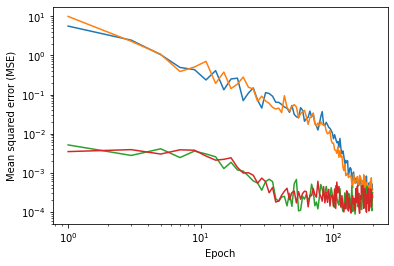

In [12]:
plt.loglog(df.Step, regular)
plt.loglog(df.Step, eigenloss)
plt.loglog(df.Step, eigeninit)
plt.loglog(df.Step, both)
plt.xlabel("Epoch")
plt.ylabel("Mean squared error (MSE)")
plt.show()